<a href="https://colab.research.google.com/github/linmyint-lab/geodata/blob/main/ParticalDetctionWS_CMU2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Studying Vertical Total Electron Content (TEC) and Geomagnetic Field**

This program generates a one-day Vertical Total Electron Content (TEC) maps and diurnal plot using data from Coordinated Data Analysis Web (CDAWeb) available at https://cdaweb.gsfc.nasa.gov/ and plots Geomagnetic fields using INTERMAGNET data availab at https://intermagnet.org/

Please note that this program is intended for academic purposes only. It was developed by Lin Myint (linminmin.my@kmitl.ac.th) and team members of THAI GNSS and SPACE WEATHER - KMITL.

**Coordinated Data Analysis Web (CDAWeb)**
CDAWeb contains selected public non-solar heliophysics data from current and past heliophysics missions and projects. Many datasets from current missions are updated regularly (even daily), including reprocessing older time periods, and SPDF only preserves the latest version. To find all of the public data and documents archived by the SPDF, see the SPDF archive. To search for additional heliophysics data products, check the heliophysics data portal.

**International Real-time Magnetic Observatory Network**
Welcome to INTERMAGNET - the global network of observatories, monitoring the Earth's magnetic field. At this site you can find data and information from geomagnetic observatories around the world



In [ ]:
#!pip install pandas

In [ ]:
%matplotlib inline
import sys, time, os, subprocess, re
try: # python module for processing NASA cdf data
  import pycdfpp
  print("pycdfpp Module is installed.")
except ImportError:
  print("pycdfpp Module is not installed os installing")
  subprocess.check_call([sys.executable, "-m", "pip", "install", 'pycdfpp'])
finally:
  import pycdfpp
import numpy as np
import glob # tothe pathnames management
import requests
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import geopandas as gpd # for processing geodata
import pandas as pd # for data processing
from urllib import request
from urllib.error import URLError
from contextlib import ExitStack
import shutil
import matplotlib.animation as animation
from IPython.display import HTML
from shapely.geometry import Point, box
import matplotlib.dates as mdates
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/96.0.4664.110 Safari/537.36"}

pycdfpp Module is installed.


## Importing the library files and reading the dataset file

In [ ]:
# https://imag-data.bgs.ac.uk/GIN_V1/GINForms2
#
#
#----------------------------------------------------------------------
# upd_op_co:         Increment and serialize the operation count
# Input parameters:  op_count the current operation number
# Returns:           op_count is incremented and returned (and written to disk)
def upd_op_co(op_count):
  op_count = op_count + 1
  with open('counter.dat', 'w') as f:
    f.write('%d' % op_count)
  return op_count

#----------------------------------------------------------------------
# safemd:            Safely create a folder (no error if it already exists)
# Input parameters:  folder the directory to create
#                    op_number the operation number for this call
#                    op_count the current operation number
# Returns:           op_count is incremented and returned (and written to disk)
def safemd (folder, op_number, op_count):
  if op_number >= op_count:
    if op_number == 0:
      print ('Creating directories...')
    try:
      os.makedirs (folder, exist_ok=True)
    except OSError:
      print ('Error: unable to create directory: ' + str(folder))
      sys.exit (1)
    op_count = upd_op_co (op_count)
  return op_count

#----------------------------------------------------------------------
# getfile:           Download a file from a web server
# Input parameters:  url URL to download from
#                    local_file local file to download to
#                    n_retries number of retries to do
#                    op_number the operation number for this call
#                    gin_username the username of the GIN (or empty string)
#                    gin_password the username of the GIN (or empty string)
#                    proxy_address address of proxy server (or empty string)
#                    n_folders the number of folders to create
#                    n_downloads the number of files to download
#                    op_count the current operation number
# Returns:           op_count is incremented and returned (and written to disk)
def getfile (url, local_file, n_retries, op_number, gin_username,
             gin_password, proxy_address, n_folders,
             n_downloads, op_count):
  if op_number >= op_count:
    # tell the user what's going on
    percent = ((op_number - n_folders) * 100) / n_downloads
    print ('%d%% - downloading file: %s' % (percent, local_file))

    # remove any existing file
    try:
      os.remove (local_file)
    except FileNotFoundError:
      pass
    except OSError:
      print ('Error: unable to remove file: ' + str(local_file))
      sys.exit (1)

    # handle authentication and proxy server
    proxy = auth = None
    if len (proxy_address) > 0:
      proxy = req.ProxyHandler({'http': proxy_address, 'https': proxy_address})
    if len (gin_username) > 0:
      auth = req.HTTPBasicAuthHandler()
      auth.add_password (realm=None,
                         uri='https://imag-data.bgs.ac.uk/GIN_V1',
                         user=gin_username,
                         passwd=gin_password)
    if url.startswith ('https'):
      default_handler = request.HTTPSHandler
    else:
      default_handler = request.HTTPHandler
    if auth and proxy:
      opener = request.build_opener(proxy, auth, default_handler)
    elif auth:
      opener = request.build_opener(auth, default_handler)
    elif auth:
      opener = request.build_opener(proxy, default_handler)
    else:
      opener = request.build_opener(default_handler)

    # download the file
    success = False
    while (not success) and (n_retries > 0):
      try:
        with opener.open (url) as f_in:
          with open (local_file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out, 4096)
        success = True
      except (URLError, IOError, OSError):
        n_retries -= 1
    if not success:
      print ('Error: cannot download ' + local_file)
      sys.exit (1)

    # rename IAGA-2002 files
    dt = None
    try:
      with open(local_file, 'r') as f:
        for line in f.readlines():
          if re.search ('^ Data Type', line):
            dt = line[24:25].lower()
    except (IOError, OSError):
      pass
    if dt:
      if not dt.isalpha():
        dt = None
    if dt:
      new_local_file = local_file[:len(local_file) - 7] + dt + local_file[len(local_file) - 7:]
      try:
        os.remove (new_local_file)
      except (FileNotFoundError, OSError):
        pass
      try:
        os.rename (local_file, new_local_file)
      except (IOError, OSError):
        print ('Warning: unable to rename ' + local_file + ' to ' + new_local_file)
    else:
      print ('Warning: unable to determine data type for renaming of ' + local_file)

    op_count = upd_op_co (op_count)
  return op_count, new_local_file


In [ ]:
# @title Enter a date of interest
date_study = "2024-02-05" # @param {type:"date"}
date_study = pd.Timestamp(date_study);
# creating a cdf file name from  CDAWeb
cdf_file = "gps_tec15min_igs_"+date_study.strftime("%Y%m%d")+"_v01.cdf"

Reading TEC data from NASA Coordinated Data Analysis Web (CDAWeb)

In [ ]:
if os.path.isfile(cdf_file): # if data cdf file has been downloaded before
  print("That cdf file exist")
else:# if not, the data file will be downloaded
  url_cdaweb = "https://cdaweb.gsfc.nasa.gov/pub/data/gps/tec15min_igs/"
  url_cdf =os.path.join(url_cdaweb,str(date_study.year),cdf_file )
  query_parameters = {"downloadformat": "cdf"}
  try:
      response = requests.get(url_cdf, params=query_parameters)
      if response.status_code == 200:
          with open(cdf_file, "wb") as f:
              f.write(response.content)
      else:
          print("Failed to download the file:", response.status_code)
  except requests.ConnectionError as e:
      # Handle the connection error
      print("Connection Error:", e)
      print("The program will now exit.")
      sys.exit(1)  # Exit with a non-zero status code to indicate

cdf_data = pycdfpp.load(cdf_file) # reading cdf file
print(cdf_data)

That cdf file exist
CDF:
  version: 3.9.0
  majority: row
  compression: None

Attributes:
  TITLE: "GPS total electron content 15minute maps"
  Project: "GPS>Global Positioning System"
  Source_name: "GPS>Global Positioning System"
  Discipline: "Space Physics>Magnetospheric  Ionospheric Interactions"
  Descriptor: "tec15min> Total Electron Content 15minute"
  Data_type: "IGS>Intern. GPS Service"
  Data_version: "1"
  TEXT: [ [ "The IGS global system of satellite tracking stations, Data Centers, and Analysis Centers puts high-quality GPS data and data products on line in near real time to meet the objectives of a wide range of scientific and engineering applications and studies.  The IGS collects, archives, and distributes GPS observation data sets of sufficient accuracy to satisfy the objectives of a wide range of applications and experimentation.  These data sets are used by the IGS to generate the data products mentioned above which are made available to interested users through th

Reading World map dataset from https://www.naturalearthdata.com/
and Dip Equator line dataset from a private Google drive

In [ ]:
zip_file = "ne_110m_admin_0_countries.zip" # world map data zip file
if os.path.isfile(zip_file): #if the zip file has been downloaded before
  print("The world map file is exist")
else: # if not, the file is downloading
  print("The world map file is downloading")
  zip_file_url ='https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/110m/cultural/ne_110m_admin_0_countries.zip'
  query_parameters = {"downloadformat": "zip"}
  try:
    response = requests.get(zip_file_url, headers=headers,params=query_parameters)
    if response.status_code == 200:
      # Save the file or process the response
      with open(zip_file, "wb") as f:
        f.write(response.content)
    else:
      print("Failed to download the file:", response.status_code)
      sys.exit(1)  # Exit with a non-zero status code to indicate an error
  except requests.ConnectionError as e:
    # Handle the connection error
    print("Connection Error:", e)
    print("The program will now exit.")
    sys.exit(1)  # Exit with a non-zero status code to indicate an error
# reading world map dataset as geodataframe
world = gpd.read_file(zip_file)

dipEqLin_file = "dipEquatorLine.csv"
if os.path.isfile(dipEqLin_file): # if data cdf file has been downloaded before
  print("That dip Equator file exist")
else:
  # reading dip equator line coordinates as pandas dataframe and geodataframe
  # eq_url = 'https://drive.google.com/file/d/1PA2XUlFLkUj-qYznmd3j7vOvEq73ufSr/view?usp=sharing'
  # eq_path = 'https://drive.google.com/uc?export=download&id='+eq_url.split('/')[-2]
  eq_path = "https://raw.githubusercontent.com/linmyint-lab/geodata/1688cd5d607ed2aea13edaf8aede81f7682903af/dipEquatorLine.csv"
  print("The world map file is downloading")
  try:
    response = requests.get(eq_path, headers=headers)
    if response.status_code == 200:
      # Save the file or process the response
      with open(dipEqLin_file, "wb") as f:
        f.write(response.content)
    else:
      print("Failed to download the file:", response.status_code)
  except requests.ConnectionError as e:
    # Handle the connection error
    print("Connection Error:", e)
    print("The program will now exit.")
    sys.exit(1)  # Exit with a non-zero status code to indicate an error

# reading equator line and make it as geodataframe
df_eq = pd.read_csv(dipEqLin_file ,header=None,names=['lon','lat'])
gdf_eq = gpd.GeoSeries(gpd.points_from_xy(df_eq['lon'], df_eq['lat']),crs = "EPSG:4326") # reading world map dataset as geodataframe
del df_eq

The world map file is exist
That dip Equator file exist


Checking information of cdf file

Reading data as as geodataframe

In [ ]:
Epoch = pycdfpp.to_datetime64(cdf_data['Epoch'])
pd_Epoch = pd.to_datetime(Epoch)
lat = cdf_data['lat'].values.flatten()
lon = cdf_data['lon'].values.flatten()
num_stat = cdf_data['UQRnumStations'].values
num_sat = cdf_data['UQRnumSatellites'].values
tecUQR = cdf_data['tecUQR'].values
x, y = np.meshgrid(lon,lat)
iterables = [['TEC'],pd_Epoch.strftime('%b %d %Y %H:%M:%S')]
# col_list = pd.MultiIndex.from_product(iterables, names=["TEC", "Epoch"])
# data_df = pd.DataFrame(columns =col_list)
data_df = pd.DataFrame()
for i in range(pd_Epoch.shape[0]):
    #data_df['TEC',pd_Epoch[i].strftime('%b %d %Y %H:%M:%S')] = tecUQR[i].flatten()
    data_df[pd_Epoch[i].strftime('%b %d %Y %H:%M:%S')] = tecUQR[i].flatten()
data_df['lon']= x.flatten();
data_df['lat']= y.flatten();
# Create a GeoDataFrame by specifying the DataFrame and geometry column
data_gdf = gpd.GeoDataFrame(data_df, geometry=gpd.points_from_xy(data_df['lon'], data_df['lat']),crs = "EPSG:4326")
del data_df

Generating VTEC Global Map

In [ ]:
my_cmap = plt.get_cmap('coolwarm',)
fig, ax = plt.subplots(figsize=(10.0, 6.0));
world.plot(ax = ax, color='lightgrey', edgecolor='black')
data_gdf.plot(column = data_gdf.columns[0], ax = ax, cmap = my_cmap, vmin=0, vmax=100, alpha = 0.6, markersize=35,
              legend= True, legend_kwds = {"label":"TEC (TECu)", "orientation": "horizontal"} )
gdf_eq.plot(ax = ax, markersize=1, edgecolor='black')
ax.set_xlim(-180,180)
ax.set_ylim(-90,90)
ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[0].strftime('%b %d %Y %H:%M:%S'))
plt.close()
def animate_plot(i):
  ax.clear()
  world.plot(ax = ax, color='lightgrey', edgecolor='black')
  data_gdf.plot(column = data_gdf.columns[i], ax = ax, cmap = my_cmap, vmin=0, vmax=100, alpha = 0.6, markersize=35)
  gdf_eq.plot(ax = ax, markersize=1, edgecolor='black')
  ax.set_xlim(x.min(),x.max())
  ax.set_ylim(y.min(),y.max())
  ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[i].strftime('%b %d %Y %H:%M:%S')+ ' UTC')
  return fig
anim = animation.FuncAnimation(fig,animate_plot,len(pd_Epoch),interval=100, repeat=False)
HTML(anim.to_html5_video())

<Figure size 640x480 with 0 Axes>

Generating VTEC Global Map near magnetic equator

In [ ]:
# polygon = box(-180, -30, 180, 30)
# poly_gdf = gpd.GeoDataFrame([1], geometry=[polygon], crs = "EPSG:4326")
# world_clipped = world.clip(polygon)
# my_cmap = plt.get_cmap('coolwarm')
# fig, ax = plt.subplots(figsize=(12,5));
# world.clip(polygon).plot(ax = ax, color='lightgrey', edgecolor='black')
# poly_gdf.clip(polygon).boundary.plot(ax=ax, color="red")
# data_gdf.clip(polygon).plot(column = data_gdf.columns[0], ax = ax, cmap = my_cmap, vmin=0, vmax=100,
#                             alpha = 0.6, markersize=50, legend= True,
#                             legend_kwds = {"label":"TEC (TECu)", "orientation": "horizontal"})
# gdf_eq.clip(polygon).plot(ax = ax, markersize=1, edgecolor='black')
# ax.set_xlim(polygon.bounds[0],polygon.bounds[2])
# ax.set_ylim(polygon.bounds[1],polygon.bounds[3])
# ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[0].strftime('%b %d %Y %H:%M:%S'))
# #plt.gca().set_aspect(4)
# plt.close()
# def animate_plot(i):
#     ax.clear()
#     world.clip(polygon).plot(ax = ax, color='lightgrey', edgecolor='black')
#     data_gdf.clip(polygon).plot(column = data_gdf.columns[i], ax = ax, cmap = my_cmap,
#                                 vmin=0, vmax=100, alpha = 0.6, markersize=100)
#     gdf_eq.clip(polygon).plot(ax = ax, markersize=1, edgecolor='black')
#     ax.set_xlim(polygon.bounds[0],polygon.bounds[2])
#     ax.set_ylim(polygon.bounds[1],polygon.bounds[3])
#     ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[i].strftime('%b %d %Y %H:%M:%S')+ ' UTC')
#     return fig
# anim = animation.FuncAnimation(fig,animate_plot,len(pd_Epoch),interval=300, repeat=False)
# HTML(anim.to_html5_video())


# Ploting for each country

In [ ]:
# list of countries
list_c=world['SOVEREIGNT'].values.copy()
list_c.sort()
print(list_c)

['Afghanistan' 'Albania' 'Algeria' 'Angola' 'Antarctica' 'Argentina'
 'Armenia' 'Australia' 'Austria' 'Azerbaijan' 'Bangladesh' 'Belarus'
 'Belgium' 'Belize' 'Benin' 'Bhutan' 'Bolivia' 'Bosnia and Herzegovina'
 'Botswana' 'Brazil' 'Brunei' 'Bulgaria' 'Burkina Faso' 'Burundi'
 'Cambodia' 'Cameroon' 'Canada' 'Central African Republic' 'Chad' 'Chile'
 'China' 'Colombia' 'Costa Rica' 'Croatia' 'Cuba' 'Cyprus' 'Czechia'
 'Democratic Republic of the Congo' 'Denmark' 'Denmark' 'Djibouti'
 'Dominican Republic' 'East Timor' 'Ecuador' 'Egypt' 'El Salvador'
 'Equatorial Guinea' 'Eritrea' 'Estonia' 'Ethiopia' 'Fiji' 'Finland'
 'France' 'France' 'France' 'Gabon' 'Gambia' 'Georgia' 'Germany' 'Ghana'
 'Greece' 'Guatemala' 'Guinea' 'Guinea-Bissau' 'Guyana' 'Haiti' 'Honduras'
 'Hungary' 'Iceland' 'India' 'Indonesia' 'Iran' 'Iraq' 'Ireland' 'Israel'
 'Israel' 'Italy' 'Ivory Coast' 'Jamaica' 'Japan' 'Jordan' 'Kazakhstan'
 'Kenya' 'Kosovo' 'Kuwait' 'Kyrgyzstan' 'Laos' 'Latvia' 'Lebanon'
 'Lesotho' 'Liberi

## choose a country that you want to study its ionospheric TEC

Change from Thailand to Vietnam

In [ ]:
country_map= world[world['SOVEREIGNT']=='Thailand']
c_b = country_map.total_bounds
my_cmap = plt.get_cmap('coolwarm')
fig, ax = plt.subplots(figsize=(12,6));
country_map.plot(ax = ax, color='lightgrey', edgecolor='black')
data_gdf.clip(box(c_b[0],c_b[1],c_b[2],c_b[3])).plot(column = data_gdf.columns[0], ax = ax, cmap = my_cmap,
                            vmin=0, vmax=100, alpha = 0.8, markersize=1500, legend= True,
                            legend_kwds = {"label":"TEC (TECu)", "orientation": "horizontal"})
ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[0].strftime('%b %d %Y %H:%M:%S'))
ax.set_xlim(c_b[0],c_b[2])
ax.set_ylim(c_b[1],c_b[3])
plt.close()
def animate_plot(i):
    ax.clear()
    country_map.plot(ax = ax, color='lightgrey',edgecolor='black')
    data_gdf.clip(box(c_b[0],c_b[1],c_b[2],c_b[3])).plot(column = data_gdf.columns[i], ax = ax, cmap = my_cmap,
                                 vmin=0, vmax=100,alpha = 0.8, markersize=1500)
    ax.set_xlim(c_b[0],c_b[2])
    ax.set_ylim(c_b[1],c_b[3])
    ax.set_title('Vertical Total Electron Content (TEC) Map at ' + pd_Epoch[i].strftime('%b %d %Y %H:%M:%S')+ ' UTC')
    return fig
anim = animation.FuncAnimation(fig,animate_plot,len(pd_Epoch),interval=300, repeat=False)
HTML(anim.to_html5_video())

<Figure size 640x480 with 0 Axes>

# Plotting diurnal vTEC data of each coordinate location

In [ ]:
r = country_map.total_bounds
cor_list = data_gdf.clip(country_map).get_coordinates(ignore_index=True)
cor_list.sort_values(by=['x','y'],inplace=True)
cor_list.reset_index(inplace=True, drop = True)
cor_list

,x,y
0,100.0,7.5
1,100.0,12.5
2,100.0,15.0
3,100.0,17.5
4,100.0,20.0
5,105.0,15.0


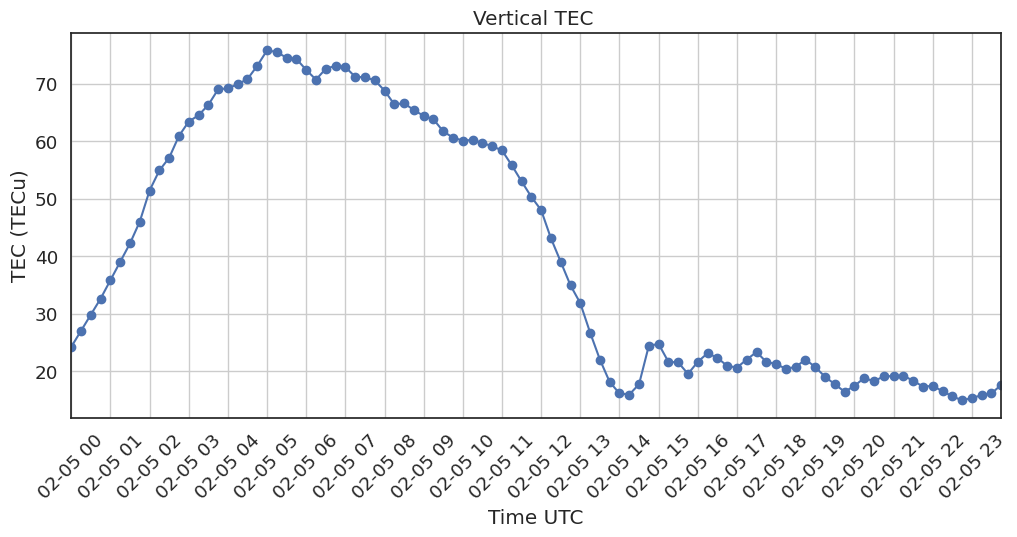

In [ ]:
# @title Choose one index number of coordinates in the list above
idx = 0 # @param {type:"integer"}

time_idx=pycdfpp.to_datetime64(cdf_data["Epoch"])
fig,ax =plt.subplots( figsize=(12,5))
lon_index =np.where(lon==cor_list['x'][idx])[0]
lat_index =np.where(lat==cor_list['y'][idx])[0]
ax.plot(time_idx, cdf_data["tecUQR"].values[:,lat_index,lon_index], marker = 'o')
ax.set_xlim(time_idx.min(),time_idx.max())
ax.grid()
ax.set( xlabel='Time UTC', ylabel='TEC (TECu)', title= 'Vertical TEC ')
plt.setp(ax.get_xticklabels(), rotation=45)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set grid line interval to 1 hour

plt.show()


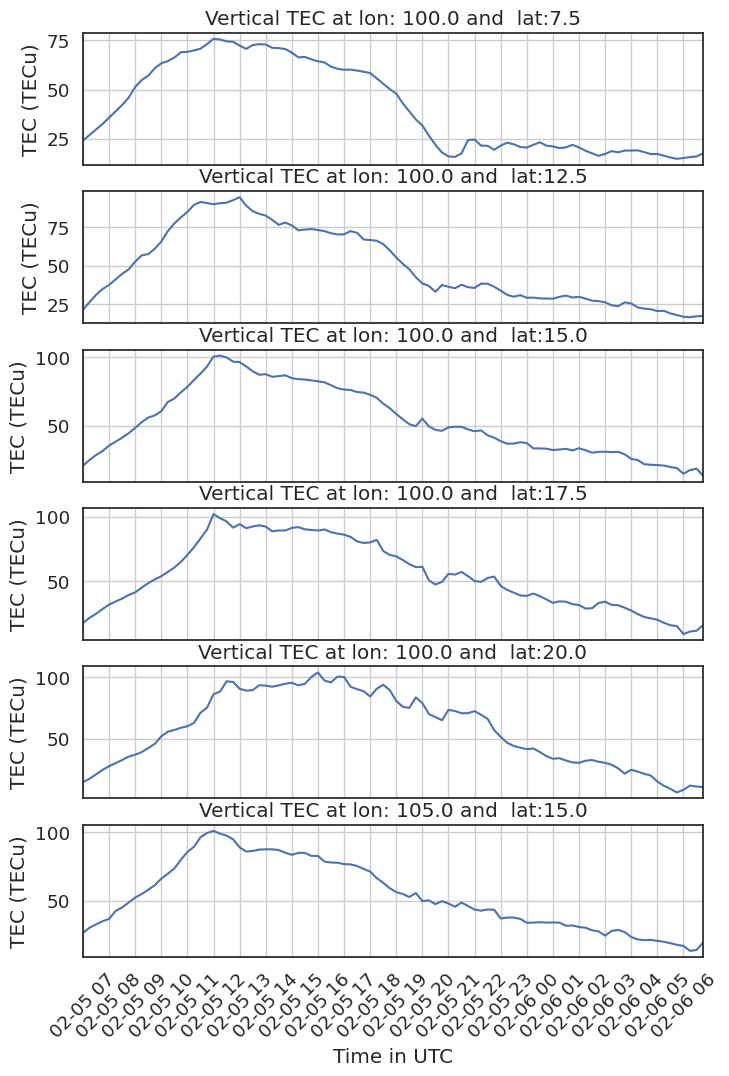

In [ ]:
# plotting for all coordinates
time_idx=pycdfpp.to_datetime64(cdf_data["Epoch"]) + pd.Timedelta(7,"h")
try:
  fig,ax =plt.subplots(nrows =len(cor_list), ncols =1, figsize=(8,12), sharex=True)
  for ind in range(len(cor_list)):
    lon_index =np.where(lon==cor_list['x'][ind])[0]
    lat_index =np.where(lat==cor_list['y'][ind])[0]
    ax[ind].plot(time_idx, cdf_data["tecUQR"].values[:,lat_index,lon_index])
    ax[ind].set( ylabel='TEC (TECu)', title= 'Vertical TEC at lon: ' +  str(lon[lon_index][0]) + ' and  lat:' + str(lat[lat_index][0]))
    ax[ind].set_xlim(time_idx.min(),time_idx.max())
    ax[ind].grid()
    ax[ind].xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set grid line interval to 1 hour

  ax[ind].set( xlabel='Time in UTC', ylabel='TEC (TECu)', title= 'Vertical TEC at lon: ' +  str(lon[lon_index][0]) + ' and  lat:' + str(lat[lat_index][0]))
  plt.setp(ax[ind].get_xticklabels(), rotation=45)
  plt.show()
except:
  print("Error")
  plt.close()
# xlabel='Time in UTC',

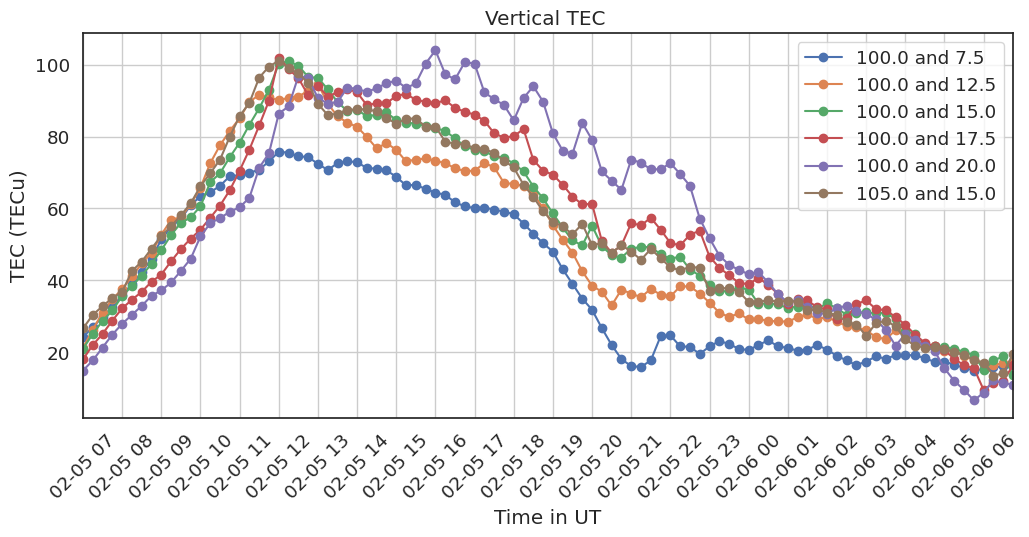

In [ ]:
time_idx=pycdfpp.to_datetime64(cdf_data["Epoch"]) + pd.Timedelta(7,"h")
fig,ax =plt.subplots( figsize=(12,5))
label = []
time_idx= pd.to_datetime(time_idx)
# for i in range(time_idx)
for ind in range(len(cor_list)):
  lon_index =np.where(lon==cor_list['x'][ind])[0]
  lat_index =np.where(lat==cor_list['y'][ind])[0]
  ax.plot(time_idx, cdf_data["tecUQR"].values[:,lat_index,lon_index], marker = 'o')
  label.append(str(lon[lon_index][0]) + ' and ' + str(lat[lat_index][0]))

ax.set_xlim(time_idx.min(),time_idx.max())
ax.grid()
ax.set( xlabel='Time in UT', ylabel='TEC (TECu)', title= 'Vertical TEC ')
ax.legend(label)
ax.xaxis.set_major_locator(mdates.HourLocator(interval=1))  # Set grid line interval to 1 hour

plt.setp(ax.get_xticklabels(), rotation=45)
plt.show()

# xlabel='Time in UTC',

### Enter the date and the station's IAGA code
Click the INTERMANET link https://intermagnet.org/metadata/#/imos to look the list of stations.

Check the data available at https://intermagnet.org/new_data_download.html

Enter the interested date and the station's IAGA code below

In [ ]:
#@title Enter Year, Month and Station Name to be studied { vertical-output: true }

# date_input = '2022-01-01' #@param {type:"date"}
stat_name = 'DLT' #@param {type:"string"}
date_input = date_study


date_input = pd.Timestamp(date_input)
total_days = 1

## Data Reading and Preprocessing

### Read magnetometer dataset as Dataframe and Screening

Read the dataset files of the day interested for calculation.

The dataset files will be downloaded to a folder name Magnetometerdata at local space.

### Download the data files

#### Read the data as dataframes. Dalat

In [ ]:
# Downloading the data
#!/usr/bin/env python3
# download.py: Download geomagnetic data from Edinburgh GIN
#
# This script is designed to download geomagnetic data
# from the Edinburgh INTERMAGNET Geomagnetic Information Node.
# To use the script, follow these steps:
#
# 1.) Create a new directory.
# 2.) Move to the new directory and copy the script there.
# 3.) Execute the script by typing 'python3 download.py'.
#
# The script keeps track of its progress through the list of files
# to download. If it fails at any time, you can restart it and it will
# resume at the point where it failed.
#
#
# Configurable parameters - these variables control use of proxy
# servers at the users site - there's also an option to use
# authentication - change them as required (though the
# defaults should work OK)
gin_username = ''
gin_password = ''
proxy_address = ''
n_retries = 4
date_input = pd.Timestamp(date_input) # change to Timestamp from string
year_month = date_input.strftime('%Y %B %d')
date_temp = date_input
time_start = date_input # the start time (minute) of target date/month
time_end = date_input - pd.to_timedelta(1,'minute') # the last time (minute) of traget date/month
loc_folder =  os.path.join(os.getcwd(),'Magnetometerdata', stat_name+ date_input.strftime('%Y%m')) # folder to save
stat_name_l = stat_name.lower() # name of station
Geo_Lo, K9_limit = 0, 0 #


try:
  with open ('counter.dat') as f: # download the data
    op_count = int(f.read())
    print('Information: resuming download after previous failure')
except (IOError, ValueError, OSError):
  op_count = 0
n_folders = 1
n_downloads = 1

folder = loc_folder
op_count = safemd(folder, 0, op_count)
loc_file = os.path.join(loc_folder,'m'+ date_input.strftime('%Y%m%d.') + stat_name_l)
ser_link = 'https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=IAGA2002&testObsys=0&observatoryIagaCode='+stat_name+'&samplesPerDay=1440&orientation=Native&publicationState=adj-or-rep&recordTermination=UNIX&dataStartDate='+date_temp.strftime('%Y-%m-%d')+'&dataDuration=1'
#ser_link = 'https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=IAGA2002&testObsys=0&observatoryIagaCode='+stat_name+'&samplesPerDay=1440&orientation=Native&publicationState=definitive&recordTermination=UNIX&dataStartDate='+date_temp.strftime('%Y-%m-%d')+'&dataDuration=1'
op_count, new_loc_file = getfile (ser_link, loc_file, n_retries, 1, gin_username, gin_password, proxy_address, n_folders, n_downloads, op_count)
  #'https://imag-data.bgs.ac.uk/GIN_V1/GINServices?Request=GetData&format=IAGA2002&testObsys=0&observatoryIagaCode=DLT&samplesPerDay=1440&orientation=Native&publicationState=adj-or-rep&recordTermination=UNIX&dataStartDate=2023-11-08&dataDuration=1'
  # tidy up
print ('100% - data download complete')
os.remove ('counter.dat')

with open(new_loc_file, "rb") as fr:
  for j in range(30):
    line = fr.readline()
    if b'K9-limit' in line:
      K9_limit  = line.decode('utf-8').split()[2]
      K9_limit = int(K9_limit) # Change K9 limit according to the information
      #print(f'K9 lower limit is {K9_limit}')
    if b'Geodetic Longitude' in line:
      Geo_Lo = line.decode('utf-8').split()[2]
      Geo_Lo = float(Geo_Lo)
    if b'DATE' in line:
      line_no = j
      print('there is DATE')
    #print(line) # display header information of file
  fr.seek(0)
print('finished')
print(f'K9 lower limit is {K9_limit}')

  # Calculate the local time difference from longitude
if Geo_Lo < 180:
  LT_diff = Geo_Lo/15 # for East
else:
  LT_diff = (180 - Geo_Lo)/15 # for West

Creating directories...
0% - downloading file: /content/Magnetometerdata/DLT202402/m20240205.dlt
100% - data download complete
there is DATE
finished
K9 lower limit is 0


In [ ]:
# Create the list of files stored at local drive and check
temp = date_input.strftime('%Y%m%d')
temp = temp[0:5]+'*'+temp[5:-1]
target_file =os.path.join(loc_folder, 'm'+temp +'*.'+ stat_name_l) # change to filename)
csv_files = glob.glob(target_file) # read all file name
if len(csv_files) == total_days :
  print(r'Selected ' + date_input.strftime('%Y %b') )
  print(f'The number of days with data is {len(csv_files)} including one day.')
elif len(csv_files) in range(1, total_days-2) :
  print(r'There are some days without data')
  print(f'The number of days with data is {len(csv_files)}')
else:
  print(r'There is no data for such time period')

# read each file name from list and read them dataframe.
if len(csv_files) > 0:
  csv_files.sort() # sort the file as date
    # column names (need to rewrite read from file)
  col_names =['YYYY-MM-DD_UT','UT', 'DOYUT', 'X (nT)','Y (nT)', 'Z (nT)','G']
    # Read all file, convert them to Dataframe and add to a list of Dataframe
  list_dfs = [pd.read_csv(f_name, delim_whitespace=True,  skiprows=line_no+1, index_col=None,
                          names=col_names, encoding= 'unicode_escape') for f_name in csv_files] # encoding= 'unicode_escape'
  Mag_df = pd.DataFrame() # A dataframe to keep all Magnetic Date
  for i in range(len(list_dfs)): # temp_df in enumerate(list_dfs):
      # Convert the date time format to YYYY-MM-DD HH:MM:SSS using to_datetime and to_timedelta (difference in time)
    date_temp = date_input + pd.Timedelta(i,'day')
    list_dfs[i]['YYYY-MM-DD_UT'] = pd.to_datetime(list_dfs[i]['YYYY-MM-DD_UT'])+pd.to_timedelta(list_dfs[i]['UT']).dt.round("s")
    list_dfs[i].rename(columns={"YYYY-MM-DD_UT":"DateTime_UT"},errors='raise',inplace=True) # Change the column name
    list_dfs[i].set_index('DateTime_UT',inplace=True) # set as index column
    if list_dfs[i].index.duplicated().any(): # delete any dublicated number
      print("There is duplicated data to be dropped.")
      list_dfs[i].drop_duplicates(keep="first",inplace=True)
    dt = (list_dfs[i].index[-1]- list_dfs[i].index[0])
    if list_dfs[i].shape[0] != dt.total_seconds()/60 +1:
     list_dfs[i] = list_dfs[i].resample('T',base=0).mean() # make every 1 minutes if there is data gap, add nan
     list_dfs[i].interpolate(method='linear',limit_direction='forward',inplace=True)
     print(f"Data gap is replace by interpolation method for day {i+1}")
    if dt.total_seconds()/60 +1 != 24 * 60:
     print(f"Data is not complete in day {i+1}")
    # to add NAN data frame if the data is missing at begining and end
    if list_dfs[i].index[0] != date_temp:
      time_gap = list_dfs[i].index[0] - date_temp
      temp_idx = pd.date_range(start=date_temp, end=date_temp + time_gap - pd.to_timedelta(1,'minute'), freq='T')
      temp_df = pd.DataFrame(columns=list_dfs[i].columns,index=temp_idx,dtype= float)
      list_dfs[i] = pd.concat([temp_df, list_dfs[i]])
      print(f'There is no data at the beginning {date_temp}')
      del temp_df, temp_idx, time_gap
    day_end = date_temp + pd.to_timedelta(1,'day') - pd.to_timedelta(1,'minute')
    if list_dfs[i].index[-1] != day_end:
      time_gap = day_end - list_dfs[i].index[-1]
      temp_idx = pd.date_range(start=list_dfs[i].index[-1] + pd.to_timedelta(1,'minute'), end = day_end, freq='T')
      temp_df = pd.DataFrame(columns=list_dfs[i].columns,index=temp_idx,dtype= float)
      list_dfs[i] = pd.concat([list_dfs[i], temp_df])
      print(f'There is no data at the end {date_temp}')
      del temp_df, temp_idx, time_gap


else: print("Sorry, There is no file.")

# Removing the outliner more than 3 * delta
mag_col = ['X (nT)','Y (nT)', 'Z (nT)','G']
temp_df = pd.DataFrame()
for i in range(len(list_dfs)):
  list_dfs[i] = list_dfs[i].replace(99999.00,np.nan)
  list_dfs[i] = list_dfs[i].replace(-9999.00,np.nan)
  temp_df = list_dfs[i][mag_col].copy()
  mean_t = temp_df.mean(numeric_only=True)
  std_t = temp_df.std(numeric_only=True)
  z_score = np.abs(temp_df - mean_t)/std_t
  temp_df = temp_df[z_score <= 3.5]
  list_dfs[i][mag_col] = temp_df
del temp_df

Selected 2024 Feb
The number of days with data is 1 including one day.


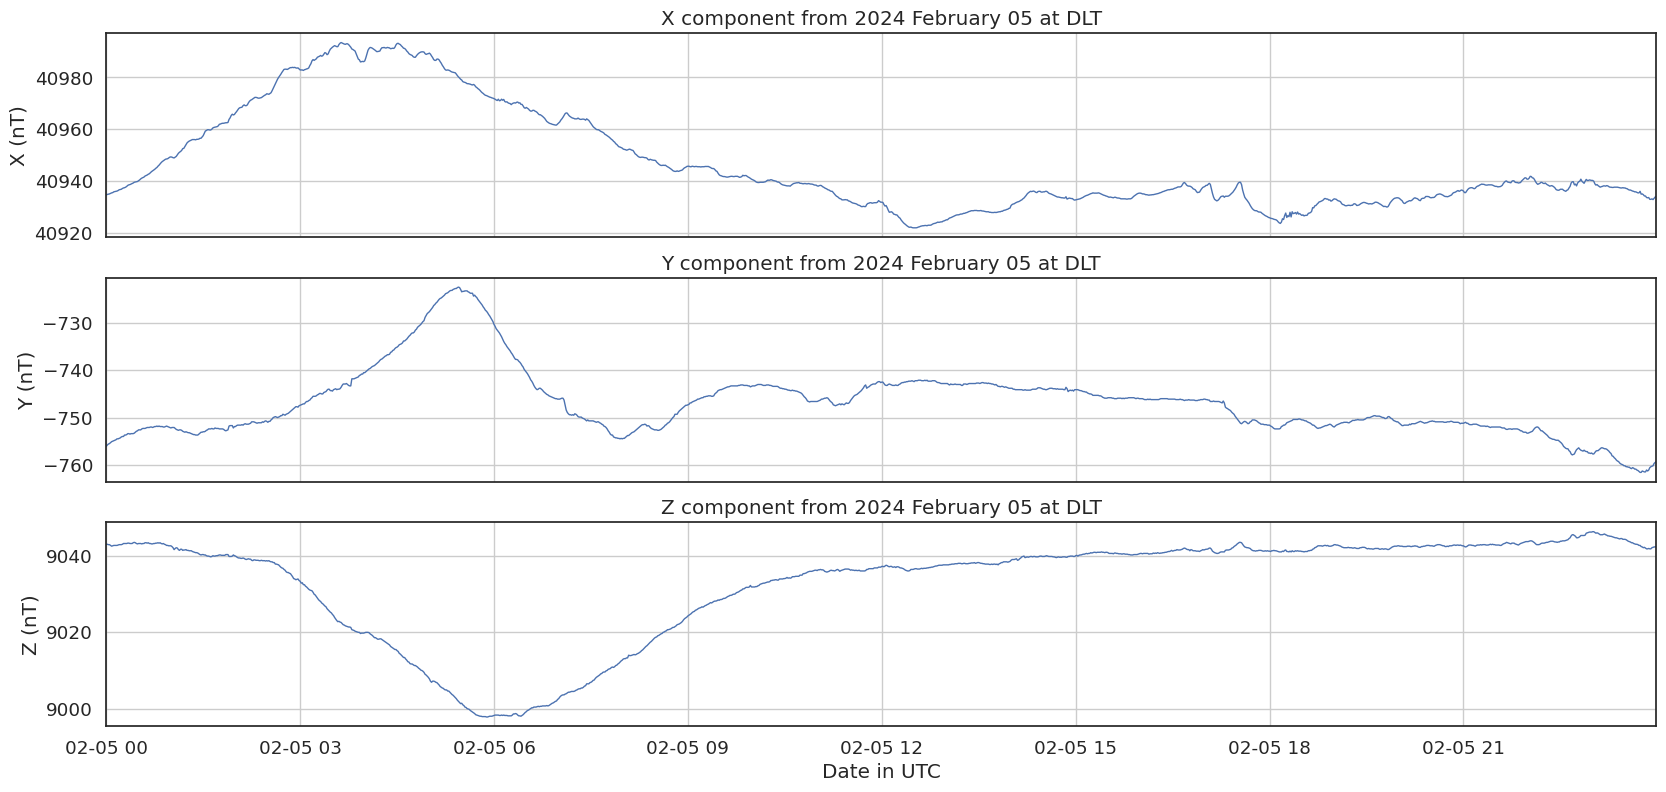

In [ ]:
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(20.0,9.0), sharex=True) #figsize=(20.0,8.0)
temp_df = list_dfs[0]
ax[0].plot(temp_df.index,temp_df['X (nT)'],linewidth=1)
ax[1].plot(temp_df.index,temp_df['Y (nT)'],linewidth=1)
ax[2].plot(temp_df.index,temp_df['Z (nT)'],linewidth=1)

  # Mag_median_df = Mag_median_df.resample('D').last()
ax[0].set( ylabel='X (nT)', title= 'X component from ' +  year_month + ' at ' + stat_name)
ax[1].set( ylabel='Y (nT)', title= 'Y component from ' +  year_month + ' at ' + stat_name)
ax[2].set(xlabel='Date in UTC', ylabel='Z (nT)', title= 'Z component from ' +  year_month+ ' at ' + stat_name)

ax[0].set_xlim(list_dfs[0].index.min(), list_dfs[0].index.max())
ax[1].set_xlim(list_dfs[0].index.min(), list_dfs[0].index.max())
ax[2].set_xlim(list_dfs[0].index.min(), list_dfs[0].index.max())
# ax[0].xaxis.set_major_locator(mticker.MultipleLocator(1))
# ax[2].xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.setp(ax[1].get_xticklabels(), rotation=45)
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

#### Plot before substracting median




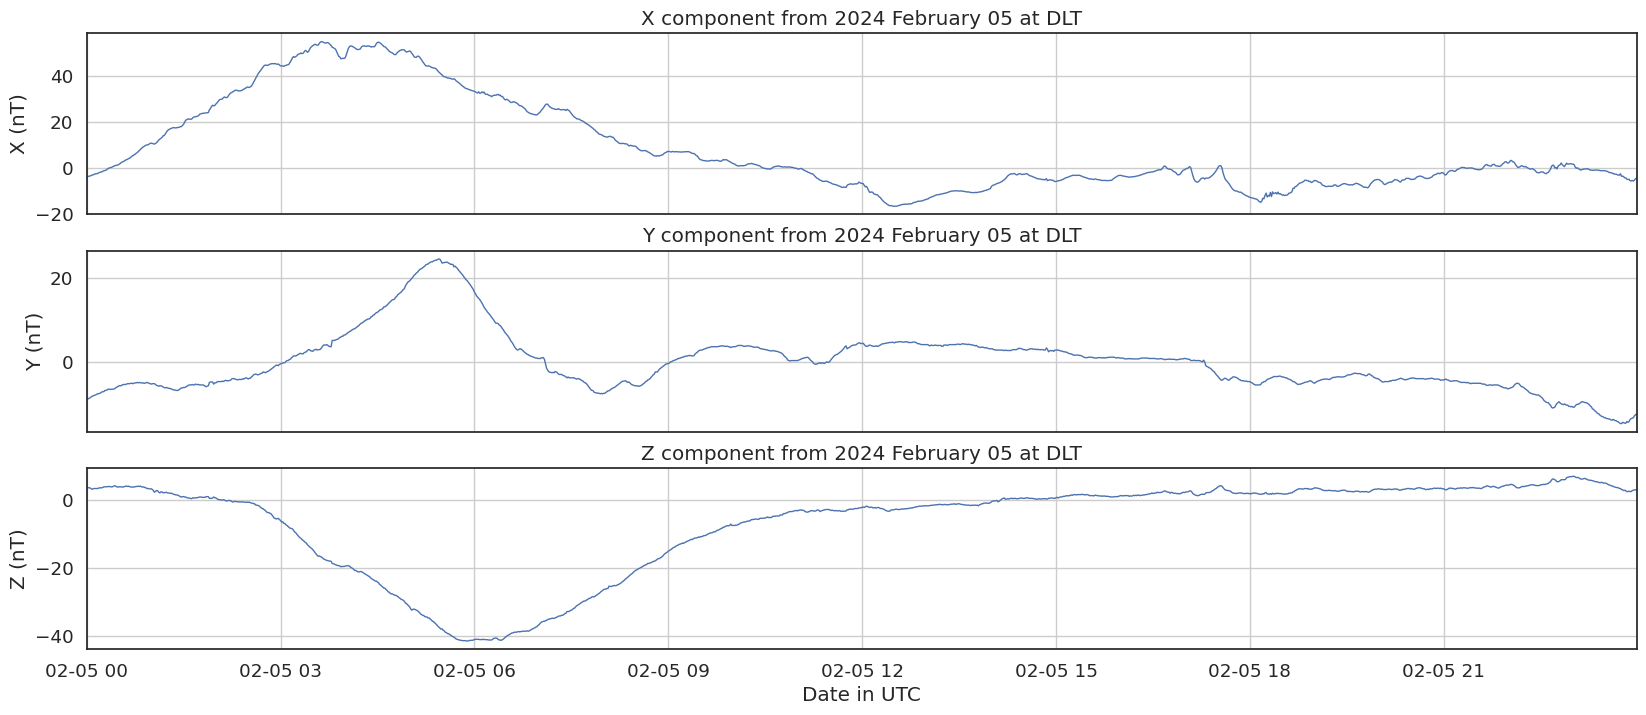

In [ ]:
mag_col = ['X (nT)','Y (nT)', 'Z (nT)','G']
Mag_df = pd.DataFrame() # A dataframe to keep all Magnetic Date
for i in range(len(list_dfs)):
  temp_df = list_dfs[i]
  temp_df.loc[:,mag_col] = temp_df.loc[:,mag_col] -temp_df.loc[:,mag_col].median()
  Mag_df = pd.concat([Mag_df, temp_df])


# After removing the daily median
fig,ax = plt.subplots(nrows=3, ncols=1, figsize=(20.0,8.0), sharex=True) #figsize=(20.0,8.0)

ax[0].plot(temp_df.index,temp_df['X (nT)'],linewidth=1)
ax[1].plot(temp_df.index,temp_df['Y (nT)'],linewidth=1)
ax[2].plot(temp_df.index,temp_df['Z (nT)'],linewidth=1)

  # Mag_median_df = Mag_median_df.resample('D').last()
ax[0].set( ylabel='X (nT)', title= 'X component from ' +  year_month + ' at ' + stat_name)
ax[1].set( ylabel='Y (nT)', title= 'Y component from ' +  year_month + ' at ' + stat_name)
ax[2].set(xlabel='Date in UTC', ylabel='Z (nT)', title= 'Z component from ' +  year_month+ ' at ' + stat_name)

ax[0].set_xlim(list_dfs[0].index.min(), list_dfs[0].index.max())
ax[1].set_xlim(list_dfs[0].index.min(), list_dfs[0].index.max())
ax[2].set_xlim(list_dfs[0].index.min(), list_dfs[0].index.max())
# ax[0].xaxis.set_major_locator(mticker.MultipleLocator(1))
# ax[2].xaxis.set_major_locator(mticker.MultipleLocator(1))
plt.setp(ax[1].get_xticklabels(), rotation=45)
ax[0].grid()
ax[1].grid()
ax[2].grid()
plt.show()

## Computing correlation between two variables over time

In [ ]:
val_1 = cdf_data["tecUQR"].values[:,lat_index,lon_index].flatten()
val_2 = temp_df['X (nT)'].values[np.arange(0,1440,15)].flatten()
val_df = pd.DataFrame({'TEC':val_1, 'Magnetic': val_2})

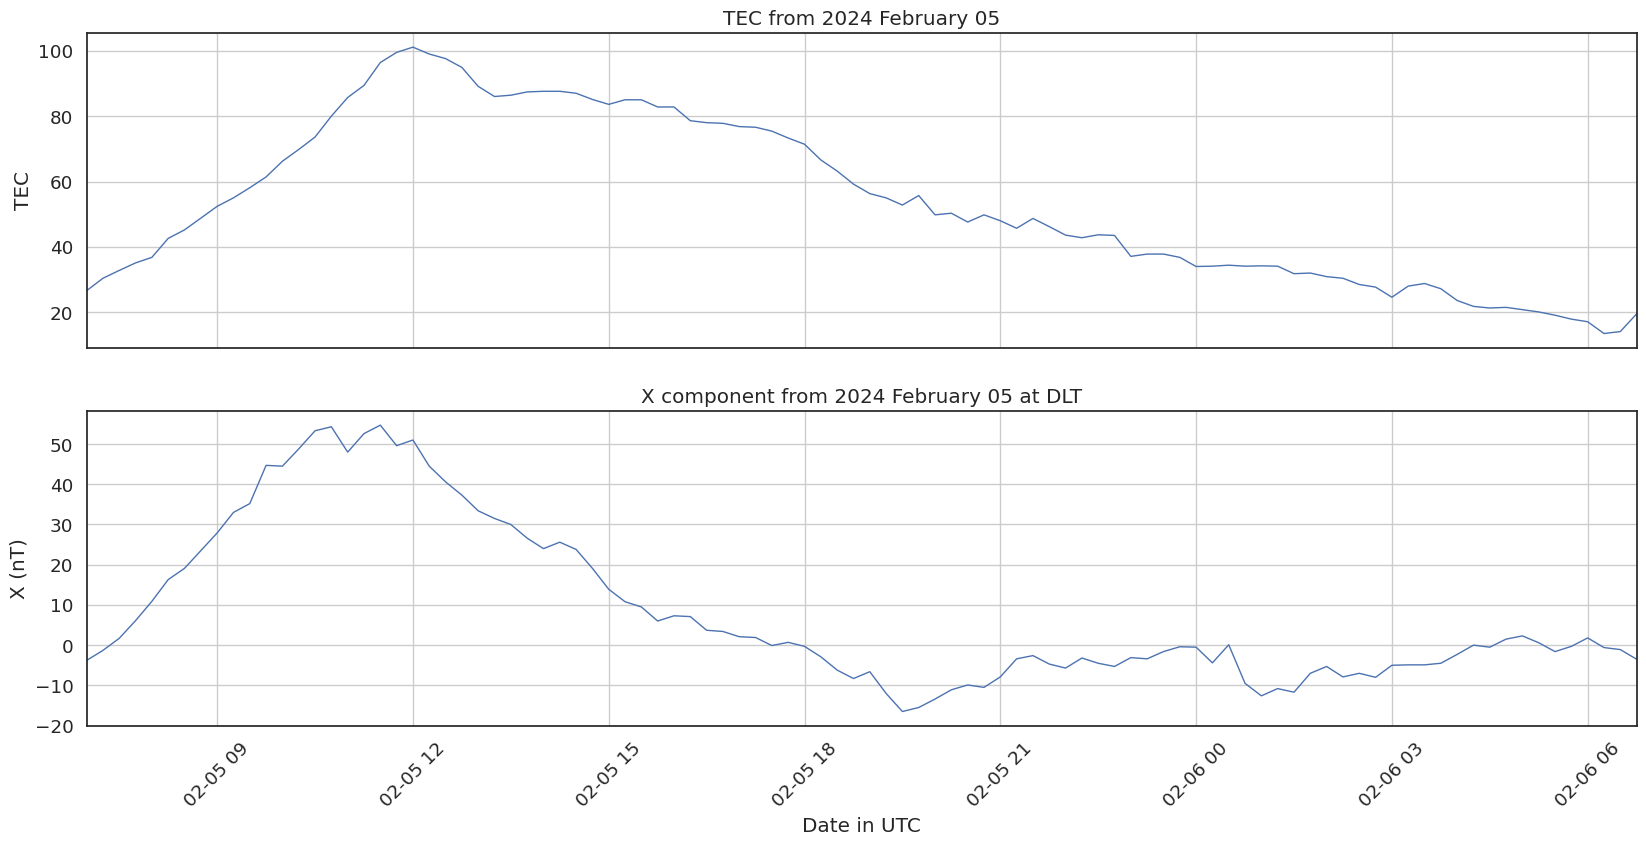

In [ ]:
fig,ax = plt.subplots(nrows=2, ncols=1, figsize=(20.0,9.0), sharex=True) #figsize=(20.0,8.0)
ax[0].plot(time_idx,val_df ['TEC'],linewidth=1)
ax[1].plot(time_idx, val_df ['Magnetic'],linewidth=1)

  # Mag_median_df = Mag_median_df.resample('D').last()
ax[0].set(ylabel='TEC', title= 'TEC from ' +  year_month)
ax[1].set(xlabel='Date in UTC', ylabel='X (nT)', title= 'X component from ' +  year_month+ ' at ' + stat_name)

ax[0].set_xlim(time_idx.min(), time_idx.max())
ax[1].set_xlim(time_idx.min(), time_idx.max())

plt.setp(ax[1].get_xticklabels(), rotation=45)
ax[0].grid()
ax[1].grid()
plt.show()

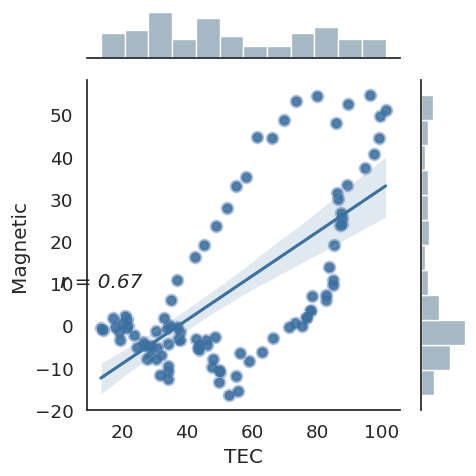

In [ ]:
import seaborn as sns
from scipy.stats import pearsonr
corr, _ = pearsonr(val_df['TEC'],val_df['Magnetic'])
sns.set(style='white', font_scale=1.2)
xlim = val_df['TEC'].max()+1
ylim = val_df['Magnetic'].max() + 1
g = sns.JointGrid(data=val_df, x = 'TEC', y='Magnetic', height=5)
g.plot_joint(sns.scatterplot, s=100, alpha=.5)
g = g.plot_joint(sns.regplot, color="xkcd:muted blue")
#g.plot(sns.regplot, sns.boxplot)
g = g.plot_marginals(sns.histplot, kde=False, bins=12, color="xkcd:bluey grey")
g.ax_joint.text(1, 9, f'r = {round(corr,2)}', fontstyle='italic')
plt.tight_layout()

# Exercise

*   Find two days: magnetic quiet day and disturbed day using the following link
https://www.spaceweatherlive.com/en/archive.html

*   Obverse variations of ionospheric TEC and round geomagnetic field using this program



